In [1]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation, DBSCAN
import sklearn.metrics.pairwise
sns.set_style('white')
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

In [2]:
PROPERTY_NAMES = ['Salt', 'Rostad', 'Flottig', 'Knaprig']
generate_palette = lambda n: sns.color_palette("Set1", n_colors=n, desat=.8)
MARKERS = ['o', 'v', 's', 'p', '^', 'h', '<']

In [3]:
def plot_pairs(data, max_cols=3, clusters=None):
    data = pd.DataFrame(data)
    colnames = data.columns
    rows = int(np.ceil(len(colnames) / max_cols))
    cols = min(max_cols, len(colnames))
    pairs = list(itertools.combinations(colnames, 2))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    if clusters is None:
        clusters = [0] * len(data)        

    if isinstance(clusters, dict):
        clusters = pd.Series(clusters)
    if not isinstance(clusters, pd.Series):
        clusters = pd.Series(data=clusters, index=data.index)
    clusters = clusters[data.index]

    colors = generate_palette(len(clusters.unique()))
    
    for (propa, propb), ax in zip(pairs, axs.flat):
        for cluster, marker, color in zip(clusters.unique(), MARKERS, colors):
            d = data[clusters == cluster]
            ax.scatter(d[propa], d[propb], marker=marker, color=color, s=40)
            ax.set_xlabel(propa)
            ax.set_ylabel(propb)
            fig.tight_layout()

def sort_scores(scores, people_clusters=None, nut_clusters=None):
    sorted_scores = scores.copy()
    if people_clusters is not None:
        assert len(people_clusters) == scores.shape[0]
        sorted_scores = sorted_scores.iloc[np.argsort(people_clusters), :]
    if nut_clusters is not None:
        assert len(nut_clusters) == scores.shape[1]
        sorted_scores = sorted_scores.iloc[:, np.argsort(nut_clusters)]
    return sorted_scores

def plot_biclustering(scores, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.matrix.heatmap(sort_scores(scores, **kwargs), ax=ax)
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    return ax

## Load data

(Loads only the latest observation for each (person, nut) combination.)

In [4]:
def load_data(paths):
    d = pd.concat(
        pd.DataFrame.from_csv(path, index_col=None, parse_dates=['Timestamp'])
        for path in paths)

    d = d.rename(
        columns={ ''
            'Din TBF': 'TBF',
            'Jordnötens nummer': 'Nöt',
            'Betygsätt totalupplevelsen': 'Betyg'
        })
    
    d['TBF'] = [v.upper() for v in d['TBF']]

    nuts = [int(v) for v in d['Nöt']]
    d['Nöt'] = nuts
    
    return d.groupby(['TBF', 'Nöt']).last().reset_index()

all_data = load_data(['raw_data/Untitled form.csv', 'raw_data/party2.csv', 'raw_data/party3.csv'])
all_data.tail()

,TBF,Nöt,Betyg,Flottig,Knaprig,Kommentar,Rostad,Salt,Timestamp
392,WWW,16,5,4,6,NaN,4,5,2016-09-24 17:33:30
393,WWW,17,5,5,5,NaN,5,6,2016-09-24 17:21:51
394,WWW,18,5,5,6,NaN,5,5,2016-09-24 17:16:23
395,WWW,19,4,5,3,NaN,3,4,2016-09-24 17:25:44
396,WWW,20,5,3,6,Speciell,4,2,2016-09-24 16:50:11


## Rename nuts

In [5]:
import json
with open('num_to_letter.json', 'r') as f:
    num_to_letter = json.load(f)
num_to_letter = {int(k): v for k, v in num_to_letter.items()}

letter_to_name = pd.read_csv('letter_to_name.csv').set_index('Kod')['Namn']

named = all_data.replace({'Nöt': num_to_letter})
named.replace({'Nöt': letter_to_name}, inplace=True)
named.head()

,TBF,Nöt,Betyg,Flottig,Knaprig,Kommentar,Rostad,Salt,Timestamp
0,ARN,Exotic snacks - Salta jordnötter,4,5,3,NaN,5,4,2016-09-24 17:18:00
1,ARN,Hemrostade - lättrostade,5,5,4,NaN,3,3,2016-09-24 16:28:39
2,ARN,Favorit - Jumbo jordnötter,4,4,4,NaN,4,4,2016-09-24 17:50:05
3,ARN,Estrella - Rostade jordnötter utan salt,3,5,3,NaN,3,2,2016-09-24 16:29:43
4,ARN,"Rostade, saltade jordnötter från Fram Järntorget",4,5,4,NaN,3,3,2016-09-24 17:03:58


In [6]:
[(num, letter_to_name[num_to_letter[num]]) for num in sorted(list(set(all_data['Nöt'].values)))]

[(1, 'Asia express - Roasted peanuts in shell'),
 (2, 'Exotic snacks - Salta jordnötter'),
 (3, 'ICA - Jordnötter rostade och saltade '),
 (4, 'Hemrostade - lättrostade'),
 (5, 'Favorit - Jumbo jordnötter'),
 (6, 'Estrella - Rostade jordnötter utan salt'),
 (7, 'Rostade, saltade jordnötter från Fram Järntorget'),
 (8, "Sainsbury's - Sea salt & cider vinegar jumbo peanuts"),
 (9, 'Hemrostade - medelrostade'),
 (10, 'Garant - Torrostade jordnötter'),
 (11, 'Saigon - Jumbo jordnötter '),
 (12, 'ICA - Torrostade jordnötter'),
 (13, 'ICA Basic - jordnötter'),
 (14, 'OLW - Torrostade jordnötter'),
 (15, 'Smiling - Ekologiska jordnötter - torrostade och havssaltade'),
 (16, 'Eldorado - Rostade & saltade jordnötter'),
 (17, 'Estrella - Salta jordnötter'),
 (18, 'OLW - Virginia traditional - large peanuts'),
 (19, 'OLW - Klassiska salta jordnötter'),
 (20, 'Garant - Extra stora jordnötter')]

In [7]:
export_order = ['Betyg', 'Flottig', 'Knaprig', 'Rostad', 'Salt', 'TBF', 'Nöt', 'Timestamp', 'Kommentar',]
named[export_order].to_csv('cleaned_data.csv', index=False, date_format='%Y-%m-%dT%H:%M:%S+0200')

# Find the winner

In [8]:
named.groupby('Nöt').mean().sort_values('Betyg', ascending=False).round(2)

,Betyg,Flottig,Knaprig,Rostad,Salt
Nöt,,,,,
Estrella - Salta jordnötter,5.39,5.00,4.94,4.50,5.33
OLW - Klassiska salta jordnötter,5.16,4.47,5.11,4.68,5.11
OLW - Virginia traditional - large peanuts,4.88,5.00,4.81,4.38,5.31
Eldorado - Rostade & saltade jordnötter,4.86,4.57,4.86,4.62,5.19
ICA - Jordnötter rostade och saltade,4.80,4.50,5.10,4.45,4.25
Exotic snacks - Salta jordnötter,4.80,4.20,4.75,4.90,4.55
ICA - Torrostade jordnötter,4.74,2.68,5.89,5.58,3.74
Saigon - Jumbo jordnötter,4.72,4.72,4.39,4.22,5.33
Sainsbury's - Sea salt & cider vinegar jumbo peanuts,4.68,5.32,4.50,3.59,4.09


# Find each person's top choice(s)

In [9]:
(
    named.sort_values('Betyg', ascending=False).groupby('TBF')
    .apply(lambda d: d[d['Betyg'] == d['Betyg'].max()])
    .set_index(['TBF', 'Nöt'])[['Betyg']]
    )

Betyg
TBF Nöt                                                      
ARN Estrella - Salta jordnötter                             6
    OLW - Klassiska salta jordnötter                        6
    ICA Basic - jordnötter                                  6
    ICA - Torrostade jordnötter                             6
    Garant - Torrostade jordnötter                          6
    Sainsbury's - Sea salt & cider vinegar jumbo pe...      6
ATG Estrella - Salta jordnötter                             7
CDN Eldorado - Rostade & saltade jordnötter                 6
    Saigon - Jumbo jordnötter                               6
    ICA - Jordnötter rostade och saltade                    6
DAG Garant - Torrostade jordnötter                          7
DDR OLW - Torrostade jordnötter                             7
    ICA - Jordnötter rostade och saltade                    7
    ICA - Torrostade jordnötter                             7
FTV ICA - Jordnötter rostade och saltade                    7
    Sainsbury's - Sea salt & cider vinegar jumbo pe...      7
GHG ICA Basic - jordnötter                                  6
GIS Saigon - Jumbo jordnötter                               6
    ICA - Torrostade jordnötter                             6
    Estrella - Salta jordnötter                             6
HVB Garant - Torrostade jordnötter                          7
    Hemrostade - lättrostade                                7
    Favorit - Jumbo jordnötter                              7
    Estrella - Rostade jordnötter utan salt                 7
    ICA - Torrostade jordnötter                             7
    Smiling - Ekologiska jordnötter - torrostade oc...      7
    Garant - Extra stora jordnötter                         7
IFK Sainsbury's - Sea salt & cider vinegar jumbo pe...      7
JPY OLW - Klassiska salta jordnötter                        7
    Exotic snacks - Salta jordnötter                        7
    ICA Basic - jordnötter                                  7
    OLW - Torrostade jordnötter                             7
KTB Sainsbury's - Sea salt & cider vinegar jumbo pe...      7
LED Exotic snacks - Salta jordnötter                        7
    OLW - Virginia traditional - large peanuts              7
MMX Sainsbury's - Sea salt & cider vinegar jumbo pe...      7
    OLW - Torrostade jordnötter                             7
NDF ICA - Torrostade jordnötter                             6
    Asia express - Roasted peanuts in shell                 6
NPV ICA - Torrostade jordnötter                             6
    Sainsbury's - Sea salt & cider vinegar jumbo pe...      6
    Garant - Torrostade jordnötter                          6
OSV Garant - Extra stora jordnötter                         6
    ICA - Jordnötter rostade och saltade                    6
PSI Estrella - Salta jordnötter                             6
    Exotic snacks - Salta jordnötter                        6
PTP Smiling - Ekologiska jordnötter - torrostade oc...      6
    Eldorado - Rostade & saltade jordnötter                 6
ROT OLW - Klassiska salta jordnötter                        6
SAS Sainsbury's - Sea salt & cider vinegar jumbo pe...      7
    OLW - Klassiska salta jordnötter                        7
SCB Asia express - Roasted peanuts in shell                 7
TPP Saigon - Jumbo jordnötter                               7
    Estrella - Rostade jordnötter utan salt                 7
WWW Hemrostade - medelrostade                               6
    OLW - Torrostade jordnötter                             6
    Asia express - Roasted peanuts in shell                 6

# Scatter properties against each other (with pairwise regressions)

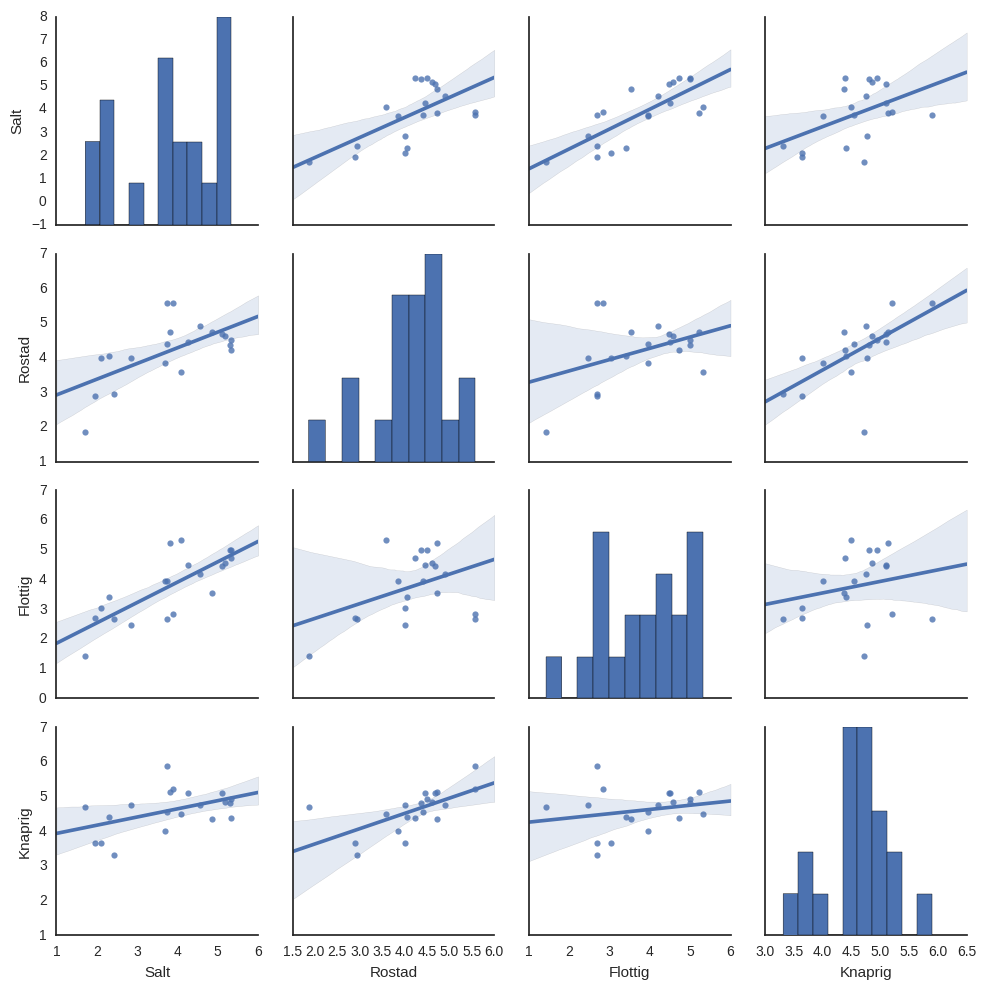

In [10]:
sns.pairplot(data=named.groupby('Nöt').mean()[PROPERTY_NAMES], kind='reg');

## Compute people $\times$ scores matrix

In [11]:
raw_scores = named.set_index(['TBF', 'Nöt'])['Betyg'].unstack()

# Impute missing values with mean for peanut
scores = raw_scores.apply(lambda row: row.where(row.notnull(), raw_scores.mean()), axis=1)

# Mean properties of nuts
nuts = named.groupby('Nöt')[PROPERTY_NAMES].mean()

## Inspect the data

In [12]:
raw_scores.round(2)

Nöt,Asia express - Roasted peanuts in shell,Eldorado - Rostade & saltade jordnötter,Estrella - Rostade jordnötter utan salt,Estrella - Salta jordnötter,Exotic snacks - Salta jordnötter,Favorit - Jumbo jordnötter,Garant - Extra stora jordnötter,Garant - Torrostade jordnötter,Hemrostade - lättrostade,Hemrostade - medelrostade,ICA - Jordnötter rostade och saltade,ICA - Torrostade jordnötter,ICA Basic - jordnötter,OLW - Klassiska salta jordnötter,OLW - Torrostade jordnötter,OLW - Virginia traditional - large peanuts,"Rostade, saltade jordnötter från Fram Järntorget",Saigon - Jumbo jordnötter,Sainsbury's - Sea salt & cider vinegar jumbo peanuts,Smiling - Ekologiska jordnötter - torrostade och havssaltade
TBF,,,,,,,,,,,,,,,,,,,,
ARN,NaN,5.0,3.0,6.0,4.0,4.0,3.0,6.0,5.0,NaN,NaN,6.0,6.0,6.0,NaN,5.0,4.0,5.0,6.0,3.0
ATG,5.0,6.0,3.0,7.0,5.0,2.0,4.0,2.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,6.0,2.0,3.0,5.0,4.0
CDN,5.0,6.0,NaN,NaN,NaN,NaN,3.0,4.0,5.0,4.0,6.0,3.0,5.0,NaN,4.0,NaN,NaN,6.0,2.0,3.0
DAG,2.0,6.0,6.0,6.0,6.0,4.0,2.0,7.0,NaN,2.0,4.0,NaN,2.0,4.0,5.0,4.0,2.0,NaN,5.0,1.0
DDR,5.0,5.0,4.0,5.0,5.0,3.0,4.0,3.0,5.0,4.0,7.0,7.0,4.0,6.0,7.0,5.0,2.0,5.0,6.0,5.0
FTV,3.0,6.0,6.0,6.0,5.0,3.0,3.0,3.0,4.0,4.0,7.0,3.0,6.0,NaN,2.0,NaN,4.0,5.0,7.0,4.0
GHG,5.0,3.0,4.0,NaN,4.0,4.0,5.0,2.0,3.0,NaN,4.0,2.0,6.0,NaN,2.0,NaN,4.0,NaN,5.0,3.0
GIS,4.0,5.0,3.0,6.0,5.0,3.0,4.0,2.0,2.0,3.0,5.0,6.0,2.0,5.0,5.0,5.0,3.0,6.0,5.0,3.0
HVB,6.0,5.0,7.0,6.0,6.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,NaN,6.0,NaN,6.0,NaN,NaN,5.0,7.0


In [13]:
scores.round(2)

Nöt,Asia express - Roasted peanuts in shell,Eldorado - Rostade & saltade jordnötter,Estrella - Rostade jordnötter utan salt,Estrella - Salta jordnötter,Exotic snacks - Salta jordnötter,Favorit - Jumbo jordnötter,Garant - Extra stora jordnötter,Garant - Torrostade jordnötter,Hemrostade - lättrostade,Hemrostade - medelrostade,ICA - Jordnötter rostade och saltade,ICA - Torrostade jordnötter,ICA Basic - jordnötter,OLW - Klassiska salta jordnötter,OLW - Torrostade jordnötter,OLW - Virginia traditional - large peanuts,"Rostade, saltade jordnötter från Fram Järntorget",Saigon - Jumbo jordnötter,Sainsbury's - Sea salt & cider vinegar jumbo peanuts,Smiling - Ekologiska jordnötter - torrostade och havssaltade
TBF,,,,,,,,,,,,,,,,,,,,
ARN,4.29,5.00,3.0,6.00,4.0,4.00,3.0,6.00,5.00,3.55,4.8,6.00,6.00,6.00,4.26,5.00,4.00,5.00,6.00,3.00
ATG,5.00,6.00,3.0,7.00,5.0,2.00,4.0,2.00,1.00,5.00,6.0,5.00,2.00,6.00,6.00,6.00,2.00,3.00,5.00,4.00
CDN,5.00,6.00,4.0,5.39,4.8,3.35,3.0,4.00,5.00,4.00,6.0,3.00,5.00,5.16,4.00,4.88,2.89,6.00,2.00,3.00
DAG,2.00,6.00,6.0,6.00,6.0,4.00,2.0,7.00,3.55,2.00,4.0,4.74,2.00,4.00,5.00,4.00,2.00,4.72,5.00,1.00
DDR,5.00,5.00,4.0,5.00,5.0,3.00,4.0,3.00,5.00,4.00,7.0,7.00,4.00,6.00,7.00,5.00,2.00,5.00,6.00,5.00
FTV,3.00,6.00,6.0,6.00,5.0,3.00,3.0,3.00,4.00,4.00,7.0,3.00,6.00,5.16,2.00,4.88,4.00,5.00,7.00,4.00
GHG,5.00,3.00,4.0,5.39,4.0,4.00,5.0,2.00,3.00,3.55,4.0,2.00,6.00,5.16,2.00,4.88,4.00,4.72,5.00,3.00
GIS,4.00,5.00,3.0,6.00,5.0,3.00,4.0,2.00,2.00,3.00,5.0,6.00,2.00,5.00,5.00,5.00,3.00,6.00,5.00,3.00
HVB,6.00,5.00,7.0,6.00,6.0,7.00,7.0,7.00,7.00,6.00,6.0,7.00,4.25,6.00,4.26,6.00,2.89,4.72,5.00,7.00


In [14]:
nuts.round(2)

,Salt,Rostad,Flottig,Knaprig
Nöt,,,,
Asia express - Roasted peanuts in shell,1.71,1.86,1.43,4.71
Eldorado - Rostade & saltade jordnötter,5.19,4.62,4.57,4.86
Estrella - Rostade jordnötter utan salt,2.30,4.05,3.40,4.40
Estrella - Salta jordnötter,5.33,4.50,5.00,4.94
Exotic snacks - Salta jordnötter,4.55,4.90,4.20,4.75
Favorit - Jumbo jordnötter,3.70,3.85,3.95,4.00
Garant - Extra stora jordnötter,3.82,4.73,5.23,5.14
Garant - Torrostade jordnötter,4.86,4.73,3.55,4.36
Hemrostade - lättrostade,1.95,2.90,2.70,3.65


In [15]:
scores.round(2)

Nöt,Asia express - Roasted peanuts in shell,Eldorado - Rostade & saltade jordnötter,Estrella - Rostade jordnötter utan salt,Estrella - Salta jordnötter,Exotic snacks - Salta jordnötter,Favorit - Jumbo jordnötter,Garant - Extra stora jordnötter,Garant - Torrostade jordnötter,Hemrostade - lättrostade,Hemrostade - medelrostade,ICA - Jordnötter rostade och saltade,ICA - Torrostade jordnötter,ICA Basic - jordnötter,OLW - Klassiska salta jordnötter,OLW - Torrostade jordnötter,OLW - Virginia traditional - large peanuts,"Rostade, saltade jordnötter från Fram Järntorget",Saigon - Jumbo jordnötter,Sainsbury's - Sea salt & cider vinegar jumbo peanuts,Smiling - Ekologiska jordnötter - torrostade och havssaltade
TBF,,,,,,,,,,,,,,,,,,,,
ARN,4.29,5.00,3.0,6.00,4.0,4.00,3.0,6.00,5.00,3.55,4.8,6.00,6.00,6.00,4.26,5.00,4.00,5.00,6.00,3.00
ATG,5.00,6.00,3.0,7.00,5.0,2.00,4.0,2.00,1.00,5.00,6.0,5.00,2.00,6.00,6.00,6.00,2.00,3.00,5.00,4.00
CDN,5.00,6.00,4.0,5.39,4.8,3.35,3.0,4.00,5.00,4.00,6.0,3.00,5.00,5.16,4.00,4.88,2.89,6.00,2.00,3.00
DAG,2.00,6.00,6.0,6.00,6.0,4.00,2.0,7.00,3.55,2.00,4.0,4.74,2.00,4.00,5.00,4.00,2.00,4.72,5.00,1.00
DDR,5.00,5.00,4.0,5.00,5.0,3.00,4.0,3.00,5.00,4.00,7.0,7.00,4.00,6.00,7.00,5.00,2.00,5.00,6.00,5.00
FTV,3.00,6.00,6.0,6.00,5.0,3.00,3.0,3.00,4.00,4.00,7.0,3.00,6.00,5.16,2.00,4.88,4.00,5.00,7.00,4.00
GHG,5.00,3.00,4.0,5.39,4.0,4.00,5.0,2.00,3.00,3.55,4.0,2.00,6.00,5.16,2.00,4.88,4.00,4.72,5.00,3.00
GIS,4.00,5.00,3.0,6.00,5.0,3.00,4.0,2.00,2.00,3.00,5.0,6.00,2.00,5.00,5.00,5.00,3.00,6.00,5.00,3.00
HVB,6.00,5.00,7.0,6.00,6.0,7.00,7.0,7.00,7.00,6.00,6.0,7.00,4.25,6.00,4.26,6.00,2.89,4.72,5.00,7.00


## Compute principal components

In [16]:
pc_names = ['PC{}'.format(i + 1) for i in range(len(PROPERTY_NAMES))]
pcs = pd.DataFrame(
    sklearn.decomposition.PCA(n_components=len(PROPERTY_NAMES)).fit_transform(nuts[PROPERTY_NAMES]),
    columns=pc_names,
    index=nuts.index)
for col in pcs.columns:
    nuts[col] = pcs[col]

## Eyeball the nut properties

In [17]:
d = sklearn.decomposition.PCA(n_components=len(PROPERTY_NAMES)).fit(nuts[PROPERTY_NAMES])
print(PROPERTY_NAMES)
d.components_

['Salt', 'Rostad', 'Flottig', 'Knaprig']


array([[ 0.70494815,  0.38204648,  0.56576171,  0.19235976],
       [-0.01672688,  0.66101689, -0.58514255,  0.4694519 ],
       [ 0.67883483, -0.50276496, -0.5304514 ,  0.07093641],
       [ 0.20482085,  0.40536966, -0.23694556, -0.85882516]])

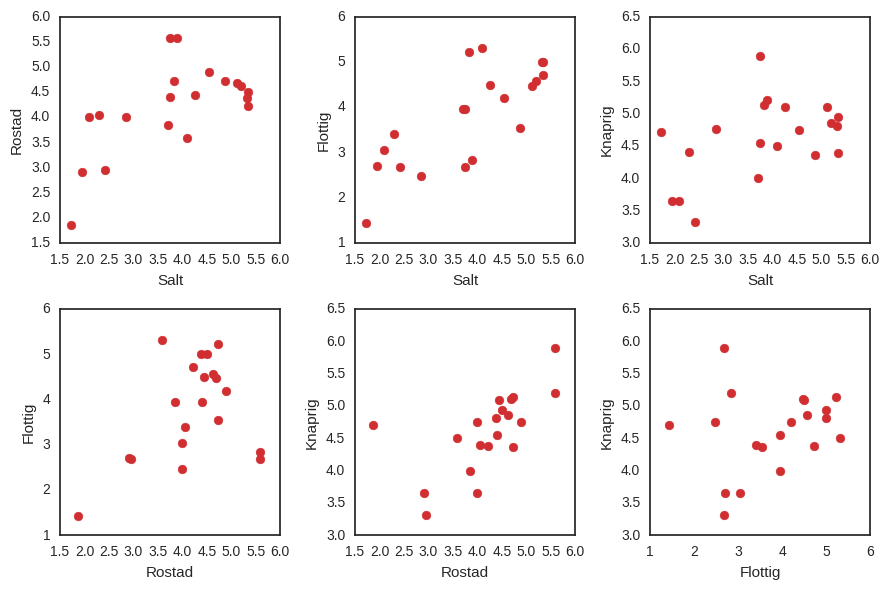

In [18]:
properties = PROPERTY_NAMES
#properties = pc_names
plot_pairs(nuts[properties])

## Try to find clusters of nut properties

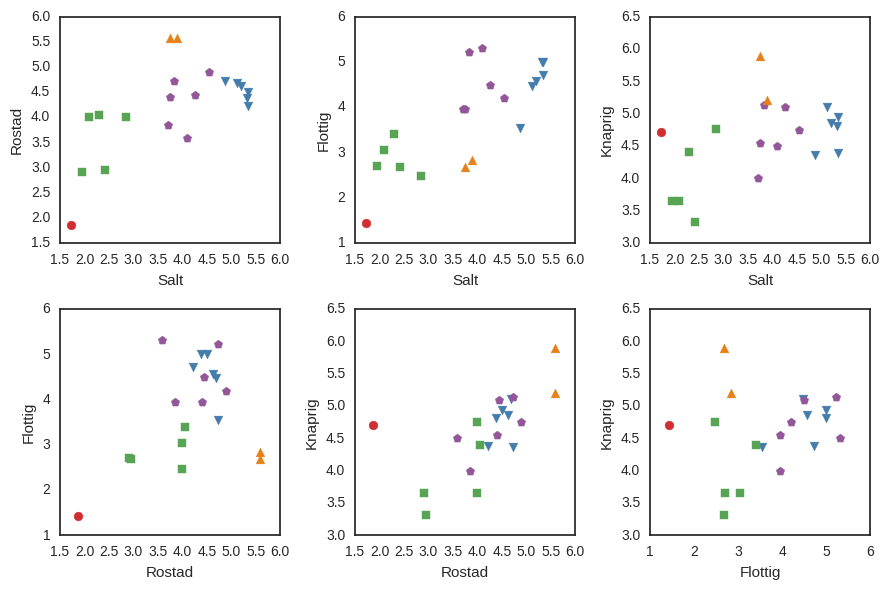

In [19]:
clustering_algorithm = AffinityPropagation()
#clustering_algorithm = DBSCAN(eps=0.3, min_samples=3)

clustering_algorithm.fit(nuts[properties])
clusters = clustering_algorithm.labels_
plot_pairs(nuts[properties], clusters=clusters)

In [20]:
nuts['clusters'] = clusters

# Inspect clusters

In [21]:
nuts.reset_index().set_index(['clusters', 'Nöt']).sort_index().round(1)

Salt  Rostad  \
clusters Nöt                                                                
0        Asia express - Roasted peanuts in shell              1.7     1.9   
1        Eldorado - Rostade & saltade jordnötter              5.2     4.6   
         Estrella - Salta jordnötter                          5.3     4.5   
         Garant - Torrostade jordnötter                       4.9     4.7   
         OLW - Klassiska salta jordnötter                     5.1     4.7   
         OLW - Virginia traditional - large peanuts           5.3     4.4   
         Saigon - Jumbo jordnötter                            5.3     4.2   
2        Estrella - Rostade jordnötter utan salt              2.3     4.0   
         Hemrostade - lättrostade                             2.0     2.9   
         Hemrostade - medelrostade                            2.1     4.0   
         Rostade, saltade jordnötter från Fram Järntorget     2.4     2.9   
         Smiling - Ekologiska jordnötter - torrostade oc...   2.9     4.0   
3        Exotic snacks - Salta jordnötter                     4.6     4.9   
         Favorit - Jumbo jordnötter                           3.7     3.8   
         Garant - Extra stora jordnötter                      3.8     4.7   
         ICA - Jordnötter rostade och saltade                 4.2     4.4   
         ICA Basic - jordnötter                               3.8     4.4   
         Sainsbury's - Sea salt & cider vinegar jumbo pe...   4.1     3.6   
4        ICA - Torrostade jordnötter                          3.7     5.6   
         OLW - Torrostade jordnötter                          3.9     5.6   

                                                             Flottig  Knaprig  \
clusters Nöt                                                                    
0        Asia express - Roasted peanuts in shell                 1.4      4.7   
1        Eldorado - Rostade & saltade jordnötter                 4.6      4.9   
         Estrella - Salta jordnötter                             5.0      4.9   
         Garant - Torrostade jordnötter                          3.5      4.4   
         OLW - Klassiska salta jordnötter                        4.5      5.1   
         OLW - Virginia traditional - large peanuts              5.0      4.8   
         Saigon - Jumbo jordnötter                               4.7      4.4   
2        Estrella - Rostade jordnötter utan salt                 3.4      4.4   
         Hemrostade - lättrostade                                2.7      3.6   
         Hemrostade - medelrostade                               3.0      3.6   
         Rostade, saltade jordnötter från Fram Järntorget        2.7      3.3   
         Smiling - Ekologiska jordnötter - torrostade oc...      2.5      4.8   
3        Exotic snacks - Salta jordnötter                        4.2      4.8   
         Favorit - Jumbo jordnötter                              4.0      4.0   
         Garant - Extra stora jordnötter                         5.2      5.1   
         ICA - Jordnötter rostade och saltade                    4.5      5.1   
         ICA Basic - jordnötter                                  4.0      4.6   
         Sainsbury's - Sea salt & cider vinegar jumbo pe...      5.3      4.5   
4        ICA - Torrostade jordnötter                             2.7      5.9   
         OLW - Torrostade jordnötter                             2.8      5.2   

                                                             PC1  PC2  PC3  \
clusters Nöt                                                                 
0        Asia express - Roasted peanuts in shell            -3.7 -0.1  1.0   
1        Eldorado - Rostade & saltade jordnötter             1.6 -0.1  0.3   
         Estrella - Salta jordnötter                         1.9 -0.4  0.3   
         Garant - Torrostade jordnötter                      0.8  0.4  0.6   
         OLW - Klassiska salta jordnötter                    1.6  0.1  0.3   
         OLW - Virginia traditional -

# Mean values by cluster

In [22]:
nuts.groupby('clusters').mean().round(1)

,Salt,Rostad,Flottig,Knaprig,PC1,PC2,PC3,PC4
clusters,,,,,,,,
0,1.7,1.9,1.4,4.7,-3.7,-0.1,1.0,-0.9
1,5.2,4.5,4.6,4.7,1.6,-0.2,0.4,0.1
2,2.3,3.6,2.9,4.0,-1.9,-0.1,-0.3,0.2
3,4.0,4.3,4.5,4.7,0.6,-0.3,-0.3,-0.1
4,3.8,5.6,2.8,5.6,0.1,2.0,-0.1,-0.0


## Try spectral biclustering

In [23]:
num_people_clusters = 1
num_nut_clusters = 4
m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters))
# m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters), method='log')
m.fit(scores)

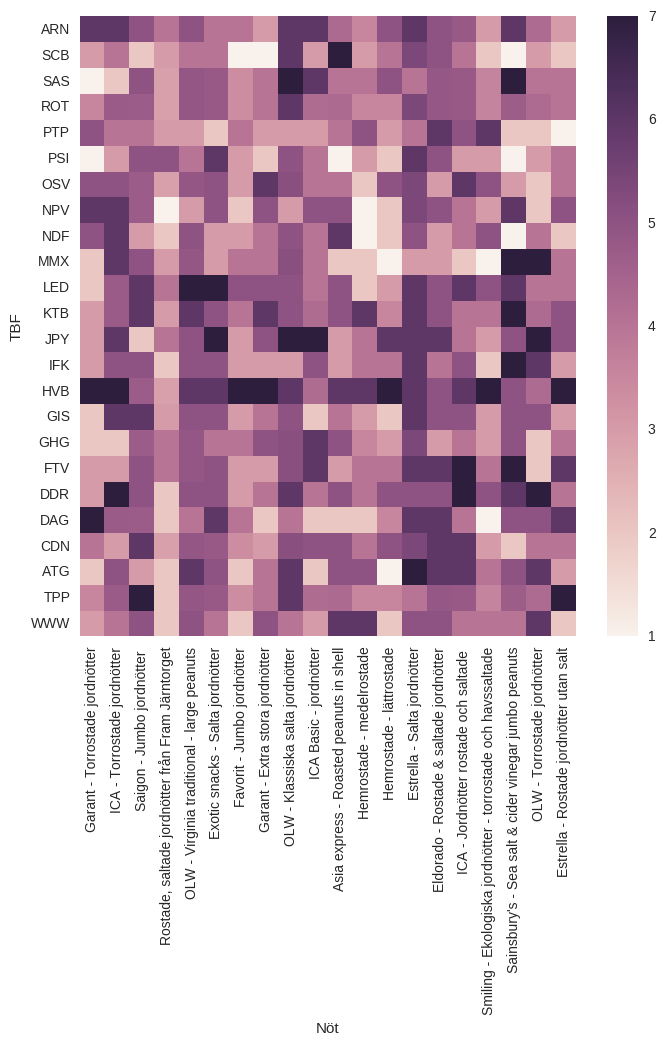

In [24]:
plot_biclustering(scores, nut_clusters=m.column_labels_, people_clusters=m.row_labels_);

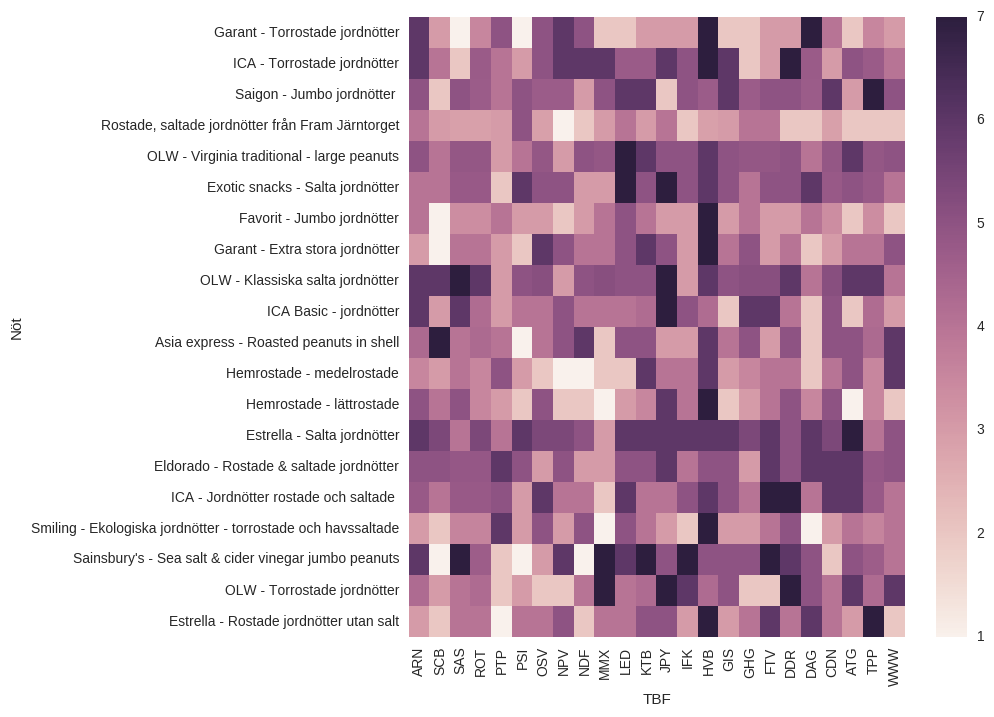

In [25]:
plot_biclustering(scores.T, nut_clusters=m.row_labels_, people_clusters=m.column_labels_);

## Check biclustering results in nut property space

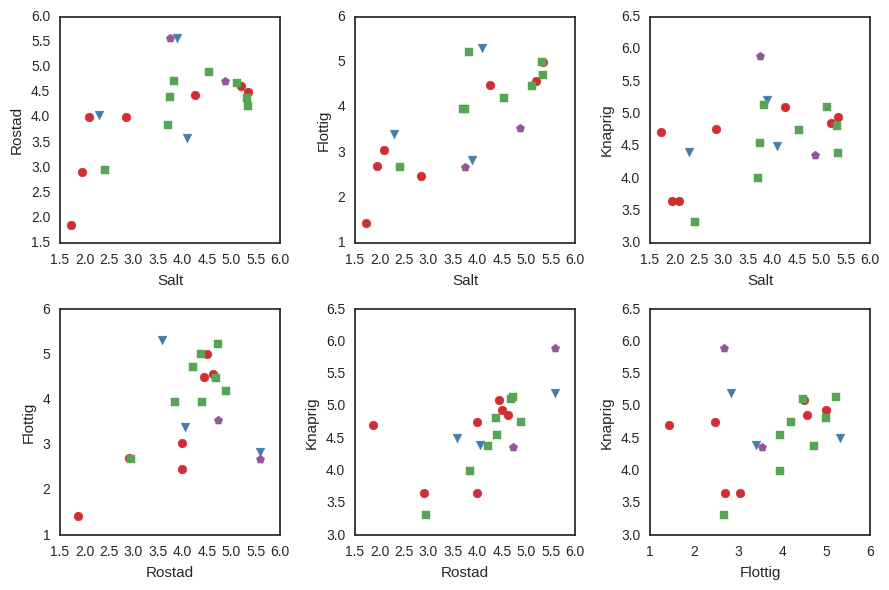

In [26]:
plot_pairs(nuts[properties], clusters=m.column_labels_)